# Вступление

Сердечно-сосудистые заболевания (ССЗ) являются причиной смерти № 1 во всем мире, унося, по оценкам, 17,9 миллиона жизней каждый год, что составляет 31% всех смертей в мире.

Сердечная недостаточность - это распространенное событие, вызванное ССЗ, и этот набор данных содержит 12 признаков, которые могут быть использованы для прогнозирования смертности от сердечной недостаточности:

* age - Возраст пациента, (40, ..., 95) лет
* sex - Пол пациента, мужчина/женщина
* anaemia - Снижение количества эритроцитов или гемоглобина (уровень гематокрита был ниже 36%), да/нет
* diabetes - Наличие у пациента сахарного диабета, да/нет
* smoking - Курящий пациент, да/нет
* creatinine_phosphokinase - Уровень фермента креатинфосфокиназа (КФК) в крови, (23, ..., 7861) мкг/л
* high_blood_pressure - Наличие у пациента гипертонии, да/нет
* ejection_fraction - Процент крови, покидающей сердце при каждом сокращении, (14, ..., 80) %
* platelets - Уровень тромбоцитов в крови, (25.01, ..., 850.00) кровяных пластинок на 1 мкл крови
* serum_creatinine - Уровень креатинина в сыворотке,	(0.50, ..., 9.40) мг/дЛ
* serum_sodium - Уровень натрия в крови, Level of sodium in the blood, (114, ..., 148) ммоль/л
* time - Период наблюдения, (4, ..., 285) дней
* DEATH_EVENT = Смерть пациента в течение периода наблюдения, да/нет

Большинство сердечно-сосудистых заболеваний можно предотвратить, обратившись к поведенческим факторам риска, таким как употребление табака, нездоровое питание и ожирение, гиподинамия и вредное употребление алкоголя, используя общепопуляционную стратегию.

Люди с сердечно-сосудистыми заболеваниями или подверженные высокому риску (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия) нуждаются в раннем выявлении и лечении, где модель машинного обучения может оказать большую помощь.

# Подготовка

In [1]:
# Устанавливаем все необходимые библиотеки
!pip install -q --upgrade pip
!pip install -q pycaret
!pip install -q sweetviz
!pip install -q pandas-profiling[notebook]
!pip install -q lofo-importance
!pip install -q tqdm==4.54.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 10.1.0 requires pyyaml~=3.12, but you have pyyaml 5.3.1 which is incompatible.
jupyterlab-git 0.10.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.0.0 which is incompatible.


In [2]:
# Подгружаем все необходимые библиотеки
import os

import numpy as np
import pandas as pd

from lofo import LOFOImportance, Dataset, plot_importance

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import GenericUnivariateSelect, f_classif, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score

from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, predict_model, calibrate_model, save_model, interpret_model, get_config, evaluate_model, finalize_model

import sweetviz as sv

from pandas_profiling import ProfileReport

%matplotlib inline

pd.set_option('max_columns', None)

/opt/conda/lib/python3.7/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Устанавливаем RANDOM_SEED
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# EDA

In [4]:
# Подгружаем датасет
df = pd.read_csv('../input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

Произведем небольшие манипуляции над названиями и порядком фичей для большего удобства.

In [5]:
# Сделаем перестановку фичей для более логичного представления

df = df[['sex', 'age', 
         'smoking', 'diabetes', 'high_blood_pressure',
         'anaemia', 'platelets', 'ejection_fraction',
         'creatinine_phosphokinase', 'serum_creatinine','serum_sodium',
         'time', 'DEATH_EVENT']]

In [6]:
# Переименуем названия фичей
df = df.rename(columns={'smoking':'smk',
                        'diabetes':'dia',
                        'anaemia':'anm',
                        'platelets':'plt',
                        'high_blood_pressure':'hbp',
                        'creatinine_phosphokinase':'cpk',
                        'ejection_fraction':'ejf',
                        'serum_creatinine':'scr',
                        'serum_sodium':'sna',
                        'DEATH_EVENT':'death'})

In [7]:
# Обработаем бинарные фичи
df['sex'] = df['sex'].apply(lambda x: 'Female' if x==0 else 'Male')
df['smk'] = df['smk'].apply(lambda x: 'No' if x==0 else 'Yes')
df['dia'] = df['dia'].apply(lambda x: 'No' if x==0 else 'Yes')
df['anm'] = df['anm'].apply(lambda x: 'No' if x==0 else 'Yes')
df['hbp'] = df['hbp'].apply(lambda x: 'No' if x==0 else 'Yes')
df['death'] = df['death'].apply(lambda x: 'No' if x==0 else 'Yes')

Для EDA анализа датасета я использовал библиотеки [SweetViz](https://github.com/fbdesignpro/sweetviz) и [Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling). Они генерят отчет в формате HTML.

In [8]:
# Формируем отчеты по датасету
my_report = sv.analyze(df)
my_report.show_html()

profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
profile.to_file("PANDAS_PROFILING_REPORT.html")


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


* Датасет состоит из 299 записей (пациентов).
* Пропущенных значений нет.
* Целевая переменная не сбалансирована (68% vs 32%).
* Количественные переменные:
    * Age: Мы видим, что средний возраст пациентов составляет 60 лет, причем большинство пациентов (<75%) моложе 70 лет и старше 40 лет. Время наблюдения после их сердечной недостаточности также варьируется от 4 дней до 285 дней, в среднем 130 дней.
    * Platelets: Тромбоциты - тип клеток крови, которые отвечают за восстановление поврежденных кровеносных сосудов. У нормального человека количество тромбоцитов составляет 150 000 - 400 000 пластинок/мл крови. В нашем наборе данных 75% пациентов имеют количество тромбоцитов в пределах этого диапазона.
    * Ejection fraction: Фракция выброса это показатель (в %) того, сколько крови откачивается из желудочка при каждом сокращении. У здорового взрослого человека эта фракция составляет 55%, а сердечная недостаточность со сниженной фракцией выброса подразумевает значение < 40%. В нашем наборе данных 75% пациентов имеют это значение < 45%, что ожидаемо, потому что все они являются пациентами с сердечной недостаточностью в первую очередь.
    * Creatinine Phosphokinase: Это фермент, который присутствует в крови и помогает в восстановлении поврежденных тканей. Высокий уровень КФК подразумевает сердечную недостаточность или травму. Нормальные уровни у мужчин составляют 55-170 мкг/л, а у женщин - 30-135 мкг/л. В нашем наборе данных, поскольку все пациенты имели сердечную недостаточность, среднее значение (550 мкг/л) и медиана (250 мкг/л) выше нормы.
    * Serum Creatinine: это продукт отходов, который вырабатывается как часть мышечного метаболизма, особенно во время распада мышц. Этот креатинин фильтруется почками, и его повышенный уровень свидетельствует о плохом сердечном выбросе и возможной почечной недостаточности. Нормальные уровни находятся в диапазоне от 0,84 до 1,21 мг/дл, а в нашем наборе данных среднее и медиана превышают 1,10 мг / дл, что довольно близко к верхней границе нормального диапазона.
    * Serum sodium: это относится к уровню натрия в крови, а высокий уровень > 135 мэкв/л называется гипернатриемией, которая считается типичной для пациентов с сердечной недостаточностью. В нашем наборе данных мы находим, что среднее значение и медиана составляют > 135 мэкв/л.
* Категориальные переменные:
    * Основываясь на статистических данных, мы получаем приблизительное представление о том, что особенности образа жизни почти одинаково распределены между теми, кто умер, и теми, кто выжил. Наибольшая разница в случае высокого кровяного давления, которое, возможно, могло бы оказать большее влияние на выживаемость сердечных больных.
* Корреляции:
    * Количественные переменные:
        * Большинство пациентов, умерших после сердечной недостаточности, имеют более низкую фракцию выброса, чем те, кто выжил. Они также, по-видимому, имеют несколько более высокие уровни сывороточного креатинина и креатинфосфокиназы. Их возраст, как правило, больше 80 лет.
        * Между признаками нет сильных корреляций, за ислючением одного случая. Переменная time (период наблюдения) будет исключена из дальнейшего анализа, т.к. она имеет очень сильную корреляцию с целевой переменной.
    * Категориальыне переменные:
        * Большое количество пациентов не курили, не страдали анемией, от высокого кровяного давления или диабета.
        * Было очень мало пациентов, которые имели все четыре особенности.
        * Многие из выживших были либо курильщиками, либо диабетиками.
        * Большинство умерших не имели никаких особенностей.
        * Многие из умерших также страдали анемией и диабетом.

In [9]:
df.drop(['time'], axis=1, inplace=True)

# Feature Selection. LOFO

Отбор признаков будем проводить в два этапа.

На первом этапе используем библиотеку [LOFO (Leave One Feature Out)](https://github.com/aerdem4/lofo-importance). Она вычисляет важность набора признаков на основе выбранной метрики для модели выбора, итеративно удаляя каждый признак из набора и оценивая производительность модели с помощью схемы проверки выбора, основанной на выбранной метрике.

Если модель не передается в качестве аргумента LofoImportance, она будет запускать LightGBM в качестве модели по умолчанию.

Пока будем использовать метрику ROC AUC.

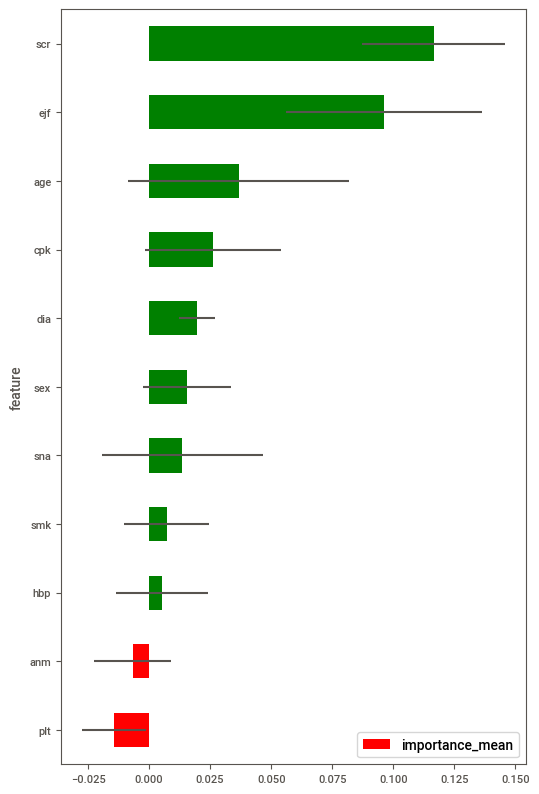

In [10]:
# Зададим нашу целевую переменную и признаки
dataset = Dataset(df=df, target='death', features=[col for col in df.columns if col != 'death'])

# Зададил схему валидации
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Зададим метрику, по которой будем определять качество модели
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# Получим среднее и значение и стандартное отклонение показателя важности
importance_df = lofo_imp.get_importance()

# Построим на графике показатели важности
plot_importance(importance_df, figsize=(6,10))

Мы видим, что самый значительный вклад в изменение метрики вносят признаки: Serum Creatinine, Ejection Fraction, Age. Зафиксируем это.

В данном ноутбуке мы не будем самостоятельно отбирать признаки, предоставим эту возможность PyCaret.

# PyCaret

Для построения и модели мы будем использовать библиотеку PyCaret. Это библиотека машинного обучения с открытым исходным кодом на Python для обучения и развертывания моделей с учителем и без учителя в low-code среде.

По сравнению с другими открытыми библиотеками машинного обучения, PyCaret – это low-code альтернатива, которая поможет заменить сотни строк кода всего парой слов. Это позволяет значительно сократить время создания и оптимизации модели.

Все операции, выполняемые PyCaret, последовательно сохраняются в пайплайне полностью готовом для развертывания. Будь то добавление пропущенных значений, преобразование категориальных данных, инженерия признаков или оптимизация гиперпараметров, PyCaret сможет все это автоматизировать.

In [11]:
# Откопируем датасет
df_copy = df.copy()

In [12]:
# Создаем конфгурацию для движка сравнения моделей МО
grid = setup(data=df_copy, target=df_copy.columns[-1], train_size=0.90, # на валидационную выборку выделяем 10%,
             html=True, silent=True, verbose=False, session_id=42,
             preprocess=True,
             fix_imbalance=True, # применяем опцию fix_imbalance, которая применяет технику Synthetic Minority Over-sampling Technique
             
             categorical_features=['sex', 'smk', 'dia', 'hbp', 'anm'],
             numeric_features=['age', 'plt', 'ejf', 'cpk', 'scr', 'sna'],

#             normalize=True, normalize_method='robust', 
#             transformation=True, transformation_method='yeo-johnson',
#             pca=True, pca_method='linear', pca_components=5,
             
             polynomial_features=True, polynomial_degree=5, #включаем генерацию полиномиальных и тригонометрических признаков и их селекцию с определенным порогом
             trigonometry_features=True,
             polynomial_threshold=0.2,
             
             feature_interaction=True, #включаем генерацию interaction-признаков и их селекцию с определенным порогом
             feature_ratio=True,
             interaction_threshold=0.1,

             feature_selection=True, feature_selection_threshold=0.2, feature_selection_method='classic', #настраиваем итоговую селекцию признаков
             
             data_split_shuffle=True,
             data_split_stratify=True,
            )

Выбор метрики.

Проанализировав несколько статей по схожим проектам МО (например https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7), я пришел к выводу, что правильнее всего будет использовать метрику MCC (Matthews correlation coefficient) как основную. Так как она является более надежным статистическим показателем, которая выдает высокое значение только в том случае, если прогноз получил хорошие результаты во всех четырех категориях матрицы путаницы (истинные положительные, ложные отрицательные, истинные отрицательные и ложные положительные), ***пропорционально как размеру положительных элементов, так и размеру отрицательных элементов в наборе данных***. Метрику AUC будем использовать как дополнительное подтверждение.

Сравним производительность разных моделей МО на 5-ти фолдовой кросс-валидации.

In [13]:
# Запустим задачу сравнения производительности множества моделей МО
best = compare_models(sort='MCC', fold=10, n_select=1, turbo=False)
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7953,0.8286,0.6764,0.7037,0.6749,0.5281,0.5398,0.1230
catboost,CatBoost Classifier,0.7842,0.7870,0.6625,0.6775,0.6543,0.5006,0.5121,11.1320
rf,Random Forest Classifier,0.7731,0.8010,0.6986,0.6360,0.6587,0.4905,0.4986,0.3400
ada,Ada Boost Classifier,0.7768,0.7938,0.6403,0.6807,0.6391,0.4822,0.4958,0.0960
gbc,Gradient Boosting Classifier,0.7655,0.8072,0.6750,0.6477,0.6266,0.4629,0.4845,0.2480
xgboost,Extreme Gradient Boosting,0.7618,0.7985,0.6375,0.6385,0.6274,0.4548,0.4631,0.7670
lr,Logistic Regression,0.7395,0.7285,0.5792,0.6252,0.5907,0.4030,0.4110,0.2320
et,Extra Trees Classifier,0.7359,0.7895,0.6056,0.5814,0.5857,0.3939,0.4000,0.2840
lda,Linear Discriminant Analysis,0.7245,0.6967,0.6278,0.5618,0.5880,0.3826,0.3887,0.0180
ridge,Ridge Classifier,0.6944,0.0000,0.5569,0.5288,0.5370,0.3119,0.3153,0.0200


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


В результате видим, что максимальное значение метрики  MCC (как впрочем и AUC) достигнуто моделью AdaBoost. Ее мы и выберем для дальнейшего изучения и оптимизации.

Создаем модель на основе AdaBoost и 10-ти фолдовой кросс-валидации.

In [14]:
# Создадим модель на основе лучшей по результатам сравнения
clf = create_model('ada', fold=10)
clf

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7407,0.7961,0.6250,0.5556,0.5882,0.4000,0.4015
1,0.7037,0.8092,0.7500,0.5000,0.6000,0.3793,0.3990
2,0.8148,0.7961,0.7500,0.6667,0.7059,0.5714,0.5735
3,0.7037,0.7469,0.4444,0.5714,0.5000,0.2941,0.2988
4,0.8148,0.8395,0.7778,0.7000,0.7368,0.5946,0.5966
5,0.8148,0.8580,0.7778,0.7000,0.7368,0.5946,0.5966
6,0.7778,0.7963,0.6667,0.6667,0.6667,0.5000,0.5000
7,0.8889,0.9568,0.7778,0.8750,0.8235,0.7429,0.7456
8,0.7778,0.6790,0.3333,1.0000,0.5000,0.4000,0.5000
9,0.7308,0.6597,0.5000,0.5714,0.5333,0.3453,0.3468


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

Визуально оценим производительность модели. В этом нам поможем дашборд PyCaret, который создается с помощью команды evaluate_model.

In [15]:
evaluate_model(clf)

,Parameters
algorithm,SAMME.R
base_estimator,None
learning_rate,1.0
n_estimators,50
random_state,42


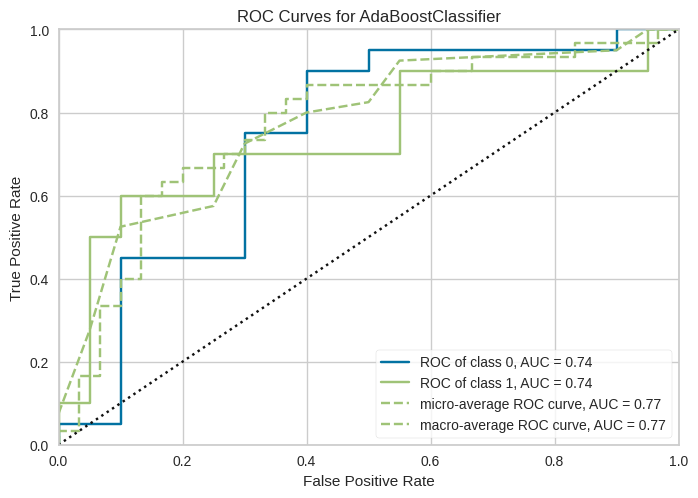

In [16]:
plot_model(clf, plot = 'auc')

Теперь проведем тюнинг модели в автоматическом режиме (метрика - MCC (среднее значение + стандартное отклонение), 5-ти фолдовая кросс-валидация)

In [17]:
tuned = tune_model(clf, optimize='mcc', n_iter=20, fold=10)
tuned

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.8322,0.7500,0.6000,0.6667,0.5031,0.5101
1,0.7407,0.7368,0.6250,0.5556,0.5882,0.4000,0.4015
2,0.8519,0.8882,1.0000,0.6667,0.8000,0.6897,0.7255
3,0.7778,0.8457,0.5556,0.7143,0.6250,0.4706,0.4781
4,0.8148,0.8765,0.8889,0.6667,0.7619,0.6154,0.6325
5,0.7778,0.8827,0.7778,0.6364,0.7000,0.5263,0.5330
6,0.8889,0.8889,0.7778,0.8750,0.8235,0.7429,0.7456
7,0.8148,0.9321,0.7778,0.7000,0.7368,0.5946,0.5966
8,0.7778,0.9012,0.5556,0.7143,0.6250,0.4706,0.4781
9,0.7308,0.6736,0.5000,0.5714,0.5333,0.3453,0.3468


AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.481,
                   n_estimators=240, random_state=42)

In [18]:
evaluate_model(tuned)

,Parameters
algorithm,SAMME
base_estimator,None
learning_rate,0.481
n_estimators,240
random_state,42


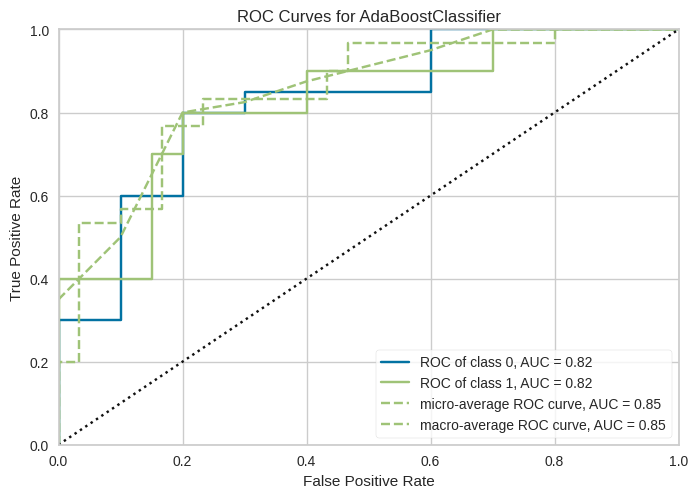

In [19]:
plot_model(tuned, plot = 'auc')

После тюнинга мы достигли небольшого улучшения по MCC и AUC c таким же небольшим увеличением стандартного отклонения от среднего значения.

Далее откалибруем модель. При выполнении классификационных экспериментов часто требуется предсказать не только метки классов, но и получить вероятность предсказания. Эта вероятность дает нам некоторую уверенность. Хорошо откалиброванные классификаторы - это вероятностные классификаторы, для которых выход вероятности может быть непосредственно интерпретирован как уровень достоверности.

In [20]:
calibrated = calibrate_model(tuned, fold=10)
calibrated

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7778,0.8289,0.7500,0.6000,0.6667,0.5031,0.5101
1,0.7407,0.7434,0.6250,0.5556,0.5882,0.4000,0.4015
2,0.8519,0.8618,1.0000,0.6667,0.8000,0.6897,0.7255
3,0.7778,0.8210,0.5556,0.7143,0.6250,0.4706,0.4781
4,0.8148,0.9012,0.8889,0.6667,0.7619,0.6154,0.6325
5,0.7778,0.8704,0.7778,0.6364,0.7000,0.5263,0.5330
6,0.8519,0.9012,0.7778,0.7778,0.7778,0.6667,0.6667
7,0.7778,0.9259,0.7778,0.6364,0.7000,0.5263,0.5330
8,0.8519,0.8889,0.5556,1.0000,0.7143,0.6250,0.6742
9,0.7308,0.6736,0.5000,0.5714,0.5333,0.3453,0.3468


CalibratedClassifierCV(base_estimator=AdaBoostClassifier(algorithm='SAMME',
                                                         base_estimator=None,
                                                         learning_rate=0.481,
                                                         n_estimators=240,
                                                         random_state=42),
                       cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
                       method='sigmoid')

In [21]:
evaluate_model(calibrated)

,Parameters
base_estimator,"AdaBoostClassifier(algorithm='SAMME', base_est..."
cv,"StratifiedKFold(n_splits=10, random_state=42, ..."
method,sigmoid


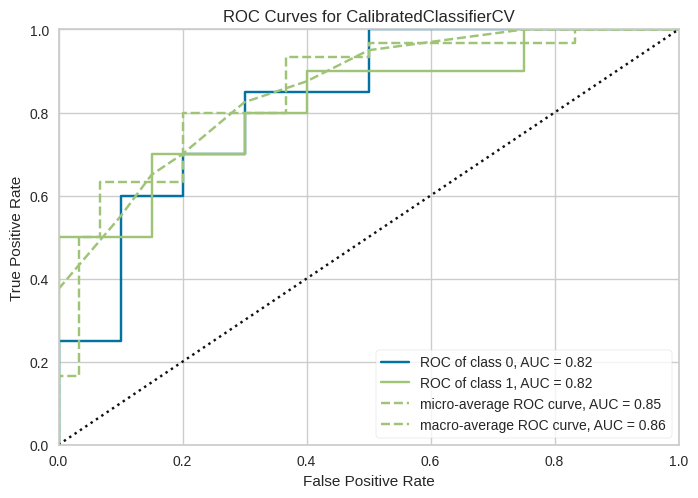

In [22]:
plot_model(calibrated, plot = 'auc')

После выполнения калибровки мы получили слегка более правильную калибровочную кривую, а также уменьшение стандартного отклонения в обеих метриках.

Предскажем значения целевой переменной на отложенной 10%-ой выборке с помощью тюнингованной и откалиброванной моделей.

In [23]:
predict_model(clf)
predict_model(tuned)
predict_model(calibrated)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.7000,0.7400,0.6000,0.5455,0.5714,0.3415,0.3424


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.7667,0.8250,0.7000,0.6364,0.6667,0.4878,0.4891


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.8000,0.8250,0.7000,0.7000,0.7000,0.5500,0.5500


,scr_Power5,age_Power5,cpk,cos(scr),tan(cpk),age,scr,sin(cpk),cos(plt),ejf_Power5,...,cpk_divide_scr_Power5,age_divide_scr_Power5,cos(scr)_divide_ejf,scr_multiply_age_Power5,ejf_Power5_divide_age_Power5,cos(scr)_divide_age,sin(cpk)_divide_cpk,death,Label,Score
0,1.610510,1.680700e+09,171.0,0.453596,4.540060,70.0,1.10,0.976591,-0.125235,777600000.0,...,106.177528,43.464485,0.007560,1.848770e+09,0.462664,0.006480,0.005711,No,No,0.8969
1,3.712929,1.160291e+09,52.0,0.267499,-6.053272,65.0,1.30,0.986628,0.089687,9765625.0,...,14.005115,17.506393,0.010700,1.508378e+09,0.008417,0.004115,0.018974,No,No,0.9626
2,0.237305,7.776000e+08,96.0,0.731689,-5.451340,60.0,0.75,0.983588,-0.465290,79235168.0,...,404.543213,252.839508,0.019255,5.832000e+08,0.101897,0.012195,0.010246,No,No,0.9731
3,40.841000,3.276800e+09,582.0,-0.504846,1.040740,80.0,2.10,-0.721079,0.124821,52521876.0,...,14.250386,1.958816,-0.014424,6.881279e+09,0.016028,-0.006311,-0.001239,No,Yes,0.7333
4,1.000000,3.125000e+08,167.0,0.540302,0.540589,50.0,1.00,-0.475550,0.846344,184528128.0,...,167.000000,50.000000,0.012007,3.125000e+08,0.590490,0.010806,-0.002848,No,No,0.6147
5,2.488321,1.306912e+08,102.0,0.362358,9.792980,42.0,1.20,0.994827,-0.178036,102400000.0,...,40.991501,16.878855,0.009059,1.568295e+08,0.783526,0.008628,0.009753,No,No,0.9838
6,1.000000,1.680700e+09,212.0,0.540302,17.370888,70.0,1.00,-0.998347,-0.143157,1419857.0,...,212.000000,70.000000,0.031782,1.680700e+09,0.000845,0.007719,-0.004709,No,No,0.5382
7,1.610510,5.032844e+08,2017.0,0.453596,0.097827,55.0,1.10,0.097362,-0.576901,9765625.0,...,1252.398071,34.150669,0.018144,5.536129e+08,0.019404,0.008247,0.000048,Yes,Yes,0.7471
8,20.523693,4.704270e+09,582.0,-0.256311,1.040740,86.0,1.83,-0.721079,-0.109882,79235168.0,...,28.357470,4.190279,-0.006745,8.608815e+09,0.016843,-0.002980,-0.001239,Yes,Yes,0.9024
9,1.000000,1.845281e+08,582.0,0.540302,1.040740,45.0,1.00,-0.721079,-0.571966,52521876.0,...,582.000000,45.000000,0.015437,1.845281e+08,0.284628,0.012007,-0.001239,Yes,No,0.9497


Финализируем и сохраним нашу модель для дальнешего развертывания.

In [24]:
final_clf = finalize_model(calibrated)
save_model(final_clf, model_name = 'rds_diploma')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['sex', 'smk', 'dia',
                                                             'hbp', 'anm'],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['age', 'plt', 'ejf',
                                                           'cpk', 'scr', 'sna'],
                                       target='death', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fil...
                              subclass='binary', target='death',
                              top_features_to_pick_percentage=None)),
                 ('pca', 'passthrough'),
                 ['trained_model',
  